# Sentiment Analysis for Amazon Fine Food User Reviews from 1999 - 2012

In [ ]:
# importing libraries
# kernel used: python 3.10.11 for tensorflow compatability
import pandas as pd 
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt 
import tensorflow as tf
nltk.download()
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zarak\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zarak\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zarak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zarak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zarak\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Step 1: Data cleaning

In [2]:
# loading dataset
df = pd.read_csv('userReviews.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5000 non-null   int64 
 1   ProductId               5000 non-null   object
 2   UserId                  5000 non-null   object
 3   ProfileName             5000 non-null   object
 4   HelpfulnessNumerator    5000 non-null   int64 
 5   HelpfulnessDenominator  5000 non-null   int64 
 6   Score                   5000 non-null   int64 
 7   Time                    5000 non-null   int64 
 8   Summary                 5000 non-null   object
 9   Text                    5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# check for duplicate rows
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Length: 5000, dtype: bool

In [4]:
# calculate percentage of missing values
round((df.isnull().sum() / df.shape[0]) * 100, 2)

Id                        0.0
ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
dtype: float64

In [ ]:
# drop irrelevant columns + fill in missing data columns (no missing data so no need to fill)
df = df.drop(columns = ['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time','Summary'])

## Step 2: Map scores

In [6]:
# turning review scores into sentiment labels
y_multi = np.array(df['Score'])
y_multi[y_multi <= 2] = 0   # negative = 1-2
y_multi[y_multi == 3] = 1   # neutral = 3
y_multi[y_multi >= 4] = 2   # positive = 4-5

# to display sentiments with words rather than 0 1 2 later on
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

## Step 3: Test-train split

In [7]:
# splitting data into testing and training
X_train, X_test, y_train, y_test = train_test_split(
    df["Text"],
    y_multi,
    test_size = 0.2, # 80/20 split
    stratify = y_multi, # stratified sampling 
    random_state = 42 # seed
)

## Step 4: Preprocessing

In [8]:
# text cleaning
def cleanText(text):
    text = text.lower() # make text lowercase
    text = re.sub(r'http\S+|www\S+', '', text) # remove URLs
    text = re.sub(r'<.*?>', '', text) # remove HTML tags
    text = re.sub(r'\S+@\S+', '', text) # remove emails
    text = re.sub(r"[^a-zA-Z\s']",'', text) # keep letters, spaces and apostrophes
    return text

example = "I didn't buy this product but got it as a gift , I tried it and it is greasy ,mushy and brown. " \
"It doesn't taste like summer sausage but like a mistery meat mush." \
"It tasted almost like potted meat but worse." \
"I am glad I didn't waste my money on the product." \
"I won't recommend."
example = cleanText(example)
print(example)

i didn't buy this product but got it as a gift  i tried it and it is greasy mushy and brown it doesn't taste like summer sausage but like a mistery meat mushit tasted almost like potted meat but worsei am glad i didn't waste my money on the producti won't recommend


In [9]:
# tokenisation
def tokenization(text):
    return word_tokenize(text)

example = tokenization(example)
print(example)

['i', 'did', "n't", 'buy', 'this', 'product', 'but', 'got', 'it', 'as', 'a', 'gift', 'i', 'tried', 'it', 'and', 'it', 'is', 'greasy', 'mushy', 'and', 'brown', 'it', 'does', "n't", 'taste', 'like', 'summer', 'sausage', 'but', 'like', 'a', 'mistery', 'meat', 'mushit', 'tasted', 'almost', 'like', 'potted', 'meat', 'but', 'worsei', 'am', 'glad', 'i', 'did', "n't", 'waste', 'my', 'money', 'on', 'the', 'producti', 'wo', "n't", 'recommend']


In [10]:
# PoS tagging
def posTag(text):   
    return pos_tag(text)

example = posTag(example)
print(example)

[('i', 'NN'), ('did', 'VBD'), ("n't", 'RB'), ('buy', 'VB'), ('this', 'DT'), ('product', 'NN'), ('but', 'CC'), ('got', 'VBD'), ('it', 'PRP'), ('as', 'IN'), ('a', 'DT'), ('gift', 'NN'), ('i', 'NN'), ('tried', 'VBD'), ('it', 'PRP'), ('and', 'CC'), ('it', 'PRP'), ('is', 'VBZ'), ('greasy', 'JJ'), ('mushy', 'NNS'), ('and', 'CC'), ('brown', 'VB'), ('it', 'PRP'), ('does', 'VBZ'), ("n't", 'RB'), ('taste', 'VB'), ('like', 'IN'), ('summer', 'NN'), ('sausage', 'NN'), ('but', 'CC'), ('like', 'IN'), ('a', 'DT'), ('mistery', 'NN'), ('meat', 'NN'), ('mushit', 'NN'), ('tasted', 'VBD'), ('almost', 'RB'), ('like', 'IN'), ('potted', 'JJ'), ('meat', 'NN'), ('but', 'CC'), ('worsei', 'NN'), ('am', 'VBP'), ('glad', 'JJ'), ('i', 'NN'), ('did', 'VBD'), ("n't", 'RB'), ('waste', 'VB'), ('my', 'PRP$'), ('money', 'NN'), ('on', 'IN'), ('the', 'DT'), ('producti', 'NN'), ('wo', 'MD'), ("n't", 'RB'), ('recommend', 'VB')]


In [11]:
# lemmatisation
def getWordnetPos(tag):
# function to turn nltk tags into wordnet tags
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN # default
    
def lemmatization(text):
# function to lemmatize text, aided by pos tags
    lemmatizer = WordNetLemmatizer()
    lemmatizedText = [lemmatizer.lemmatize(word, getWordnetPos(tag)) for word, tag in text]
    return lemmatizedText

example = lemmatization(example)
print(example)

['i', 'do', "n't", 'buy', 'this', 'product', 'but', 'get', 'it', 'a', 'a', 'gift', 'i', 'try', 'it', 'and', 'it', 'be', 'greasy', 'mushy', 'and', 'brown', 'it', 'do', "n't", 'taste', 'like', 'summer', 'sausage', 'but', 'like', 'a', 'mistery', 'meat', 'mushit', 'taste', 'almost', 'like', 'potted', 'meat', 'but', 'worsei', 'be', 'glad', 'i', 'do', "n't", 'waste', 'my', 'money', 'on', 'the', 'producti', 'wo', "n't", 'recommend']


In [12]:
# stop word removal
def stopWordRemoval(text):
    stopWords = set(stopwords.words('english')) 
    filteredText = [word for word in text if not word in stopWords] 
    return filteredText

example = stopWordRemoval(example)
print(example)

["n't", 'buy', 'product', 'get', 'gift', 'try', 'greasy', 'mushy', 'brown', "n't", 'taste', 'like', 'summer', 'sausage', 'like', 'mistery', 'meat', 'mushit', 'taste', 'almost', 'like', 'potted', 'meat', 'worsei', 'glad', "n't", 'waste', 'money', 'producti', 'wo', "n't", 'recommend']


In [13]:
# negation handling
def handleNegation(tokens):
    negationWords = {'not', 'no', 'never', "n't"}
    newTokens = []
    negateNext = False
    for token in tokens:
        if token in negationWords:
            negateNext = True
            continue  # to not keep negation words
        elif negateNext:
            newTokens.append(token + '_NEG')
            negateNext = False
        else:
            newTokens.append(token)
    return newTokens

example = handleNegation(example)
print(example)

['buy_NEG', 'product', 'get', 'gift', 'try', 'greasy', 'mushy', 'brown', 'taste_NEG', 'like', 'summer', 'sausage', 'like', 'mistery', 'meat', 'mushit', 'taste', 'almost', 'like', 'potted', 'meat', 'worsei', 'glad', 'waste_NEG', 'money', 'producti', 'wo', 'recommend_NEG']


In [14]:
# preprocessing function 
def preprocessing(rawText):
    # takes a single review, not whole corpus
    text = cleanText(rawText)
    text = tokenization(text)
    text = handleNegation(text)
    text = posTag(text)
    text = lemmatization(text)
    text = stopWordRemoval(text)
    return ' '.join(text)

example = "I didn't buy this product but got it as a gift , I tried it and it is greasy ,mushy and brown. " \
"It doesn't taste like summer sausage but like a mistery meat mush." \
"It tasted almost like potted meat but worse." \
"I am glad I didn't waste my money on the product." \
"I won't recommend."
example = preprocessing(example)
print(example)

buy_NEG product get gift try greasy mushy brown taste_NEG like summer sausage like mistery meat mushit taste almost like potted meat worsei glad waste_NEG money producti wo recommend_NEG


In [15]:
# apply preprocessing to test and train data seperately
X_train_clean = X_train.apply(preprocessing)
X_test_clean = X_test.apply(preprocessing)

## Step 5: Vectorization

In [ ]:
# vectorization using TF-IDF
vectorizer = TfidfVectorizer(
    tokenizer = str.split,# split on spaces
    preprocessor = None,
    token_pattern = None,
    min_df = 2,# removes one-off noise (<2 docs)
    max_df = 0.95,# removes very frequent words
    ngram_range = (1,2)# unigrams and bigrams
)

In [17]:
# vectorize train and test data
X_train_vec = vectorizer.fit_transform(X_train_clean) 
X_test_vec = vectorizer.transform(X_test_clean) # dont fit on test data

print(vectorizer.get_feature_names_out()[:20])

["'" "' buy" "' coffee" "' dog" "' donut" "' family" "' food" "' mix"
 "' noodle" "' snack" "' taste" "' white" "' would" "'cause" "'cause 's"
 "'d" "'d able" "'d buy" "'d eat" "'d ever"]


## Step 6: EDA

In [18]:
# rating distribution
df['Score'].value_counts().sort_index()

Score
1     469
2     290
3     395
4     712
5    3134
Name: count, dtype: int64

Text(0, 0.5, 'Count')

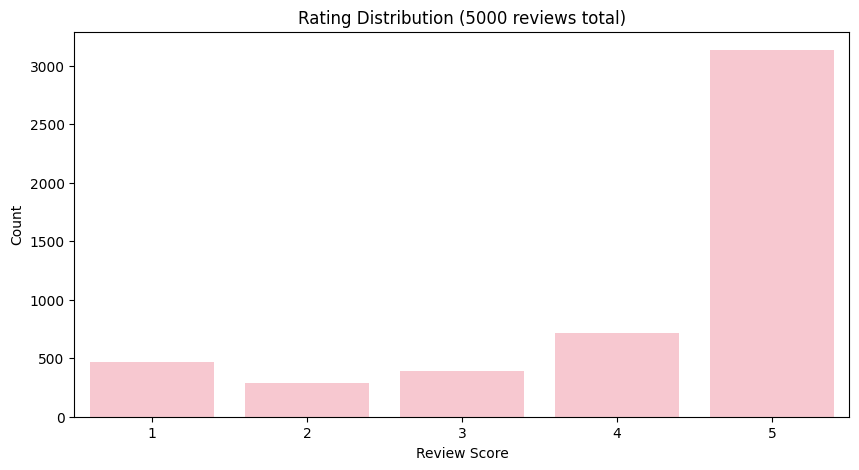

In [19]:
# rating distribution visualised
plt.figure(figsize = (10,5))
score_counts = df['Score'].value_counts().sort_index()
sns.barplot(x = score_counts.index , y = score_counts, color = 'pink')
plt.title('Rating Distribution (5000 reviews total)')
plt.xlabel('Review Score')
plt.ylabel('Count')

This graph shows that there is a large imbalance in the classes, with positive reviews dominating the dataset.

                mean  median        std  count
Sentiment                                     
Negative   85.361224    58.5  82.618336    490
Neutral    86.634146    59.0  90.770963    246
Positive   88.428341    61.0  93.961956   2477


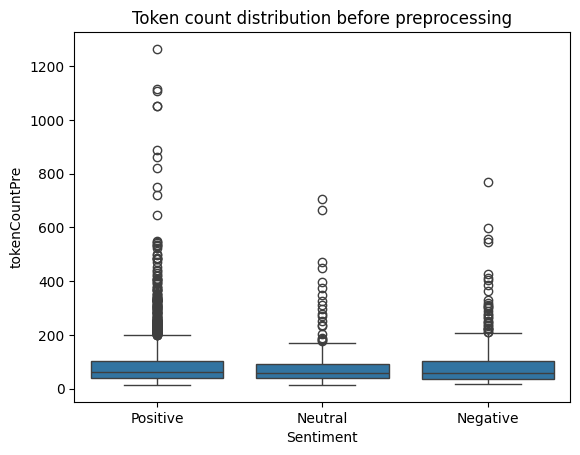

In [20]:
# text length analysis before preprocessing (but after cleaning and tokenization)
X_train_tokens = X_train.apply(word_tokenize)
X_train_token_count = X_train_tokens.apply(len)

# temp dataframe
y_train_series = pd.Series(y_train)
df_train = pd.DataFrame({
    'Sentiment': y_train_series.map(sentiment_map),               
    'tokenCountPre': X_train_token_count
})

# get stats
token_stats = df_train.groupby('Sentiment')['tokenCountPre'].agg(
    mean = 'mean',
    median = 'median',
    std = 'std',
    count = 'count'
)
print(token_stats)

# visualisation
sns.boxplot(x='Sentiment', y='tokenCountPre', data = df_train)
plt.title("Token count distribution before preprocessing")
plt.show()

                mean  median        std  count
Sentiment                                     
Negative   35.824490    25.0  33.633138    490
Neutral    36.621951    26.0  37.758840    246
Positive   37.088413    26.0  38.241039   2477


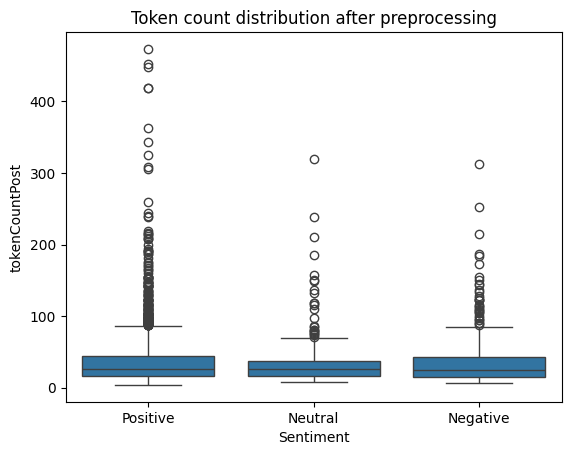

In [21]:
# text length analysis after preprocessing
X_train_clean_tokens = X_train_clean.apply(word_tokenize)
X_train_clean_token_count = X_train_clean_tokens.apply(len)

# temp dataframe
y_train_series = pd.Series(y_train)
df_train_clean = pd.DataFrame({
    'Sentiment': y_train_series.map(sentiment_map),               
    'tokenCountPost': X_train_clean_token_count
})

# get stats
clean_token_stats = df_train_clean.groupby('Sentiment')['tokenCountPost'].agg(
    mean = 'mean',
    median = 'median',
    std = 'std',
    count = 'count'
)
print(clean_token_stats)

# visualisation
sns.boxplot(x='Sentiment', y='tokenCountPost', data = df_train_clean)
plt.title("Token count distribution after preprocessing")
plt.show()

These two graphs show the importance in implementing preprocessing before training the model, making the token count about a third of what it origionally is. This means the data fed into the model is not bloated with unnecessary extra things the model cant make use of/ will confuse the model.

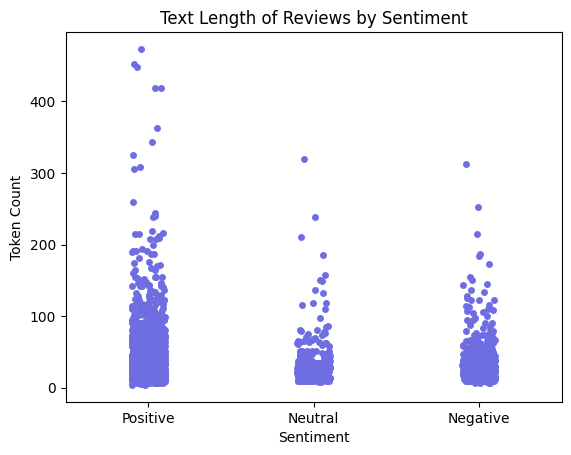

In [22]:
# scatter plot to show text length per sentiment
sns.stripplot(x = 'Sentiment', y = 'tokenCountPost', data = df_train_clean, jitter = True, color = '#6e6ee2')
plt.title('Text Length of Reviews by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Token Count')
plt.show()

This graph shows the class imbalance of the dataset again, with the positive reviews having the longest text lengths in general. This means that there is more for the model to learn about positive sentiments not only due to the large number of positive reviews, but also because the reviews themselves are longer.

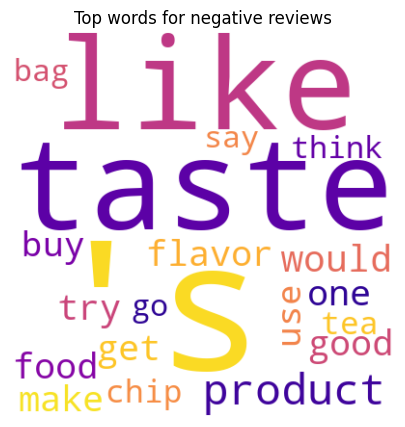

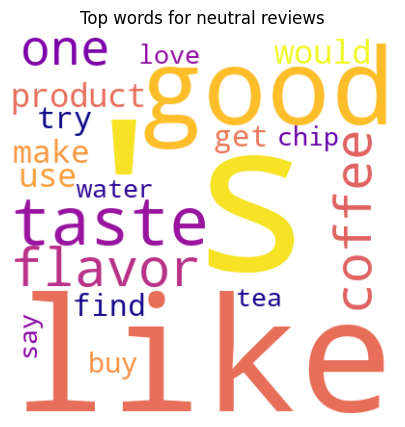

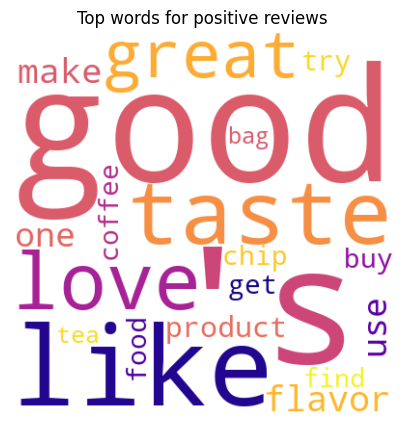

In [23]:
# vocab analysis

# tokenize and add to dataframe
X_train_tokens = X_train_clean.apply(word_tokenize)
df_train_vocab = pd.DataFrame({
    'Sentiment': y_train,
    'tokens': X_train_tokens
})

# count freq of all words for each rating
topWords = {}
for sentiment in sorted(df_train_vocab['Sentiment'].unique()):
    tokens = df_train_vocab[df_train_vocab['Sentiment'] == sentiment]['tokens'].sum()
    counter = Counter(tokens)
    topWords[sentiment] = counter.most_common(20)

# display as wordclouds
for label, counter in topWords.items():
    word_freq = dict(counter)
    wc = WordCloud(
        width=400, 
        height=400, 
        colormap='plasma', 
        background_color='white'
        ).generate_from_frequencies(word_freq)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if label == 0:
        plt.title('Top words for negative reviews')
    elif label == 1:
        plt.title('Top words for neutral reviews')
    elif label == 2:
        plt.title('Top words for positive reviews')
    plt.show()

These wordclouds show the top 20 words for each sentiment class, however, because apostrophes were kept during preprocessing (for negation handling n't) one of the most frequent words is 's which is not helpful to the model. This has not been changed though as it was deemed more necessary to handle negation for words ending in n't.

## Step 7: Modeling

In [24]:
# convert sparse matrix (default) into dense matrix for keras
X_train_vec = X_train_vec.toarray()
X_test_clean = X_test_vec.toarray()

In [25]:
# define model - simple feed forward 
model = Sequential([
    Dense(128, activation='relu', input_shape = (X_train_vec.shape[1],)),
    Dropout(0.5),
    Dense(3, activation='softmax') # multiclass
])

c:\Users\zarak\OneDrive\Documents\Uni\year 3\AI\AI Assignment\tf_env\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# compile model using adam
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# fit model
history = model.fit(X_train_vec, y_train, batch_size = 32, epochs = 10, validation_split = 0.2)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7666 - loss: 0.7604 - val_accuracy: 0.7638 - val_loss: 0.6455
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7713 - loss: 0.5359 - val_accuracy: 0.7675 - val_loss: 0.5717
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8475 - loss: 0.3717 - val_accuracy: 0.8150 - val_loss: 0.5084
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9147 - loss: 0.2273 - val_accuracy: 0.8225 - val_loss: 0.4921
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9684 - loss: 0.1404 - val_accuracy: 0.8313 - val_loss: 0.5049
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9919 - loss: 0.0794 - val_accuracy: 0.8175 - val_loss: 0.5290
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9984 - loss: 0.0467 - val_accuracy: 0.8175 - val_loss: 0.5490
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9991 - loss: 0.0303 - val_accu

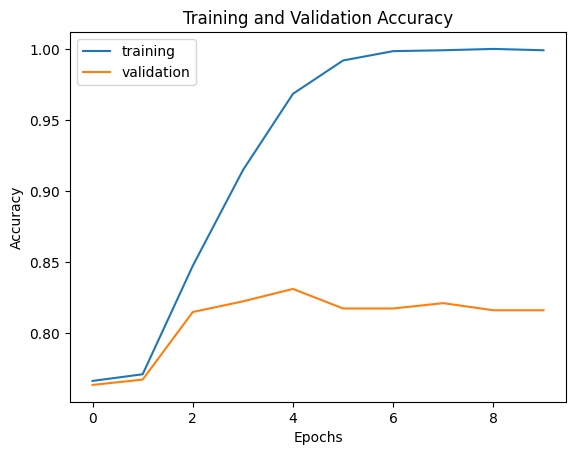

In [28]:
# plot learning curve
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Step 8: Evaluate model

In [29]:
# predictions
pred_probs = model.predict(X_test_vec) 
Y_pred = np.argmax(pred_probs, axis = 1) 
print(Y_pred[:20])

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
[2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2]


In [30]:
# evaluate on test data
loss, accuracy = model.evaluate(X_test_vec, y_test)
f1 = f1_score(y_test, Y_pred, average = 'macro') # macro treats all classes equally - since classes are imbalanced
precision = precision_score(y_test, Y_pred, average = 'macro')
recall = recall_score(y_test, Y_pred, average = 'macro')

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")
print(f"F1-score (macro): {f1:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8290 - loss: 0.5574
Test loss: 0.5574
Test accuracy: 0.8290
F1-score (macro): 0.537
Precision (macro): 0.635
Recall (macro): 0.516


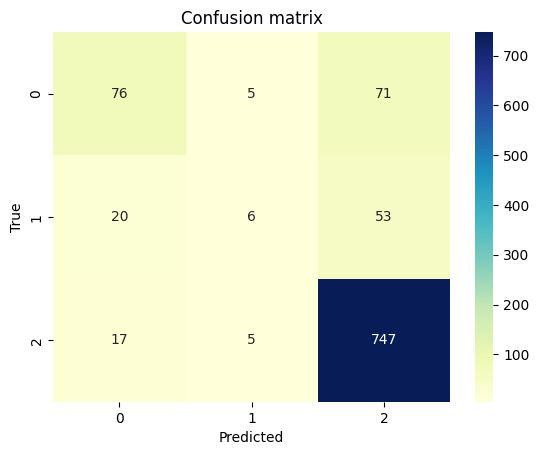

In [31]:
# confusion matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

## Step 9: Demonstration on unseen reviews

In [32]:
def demo(review):
    # review is preprocessed and vectorized
    preprocessedReview = preprocessing(review)
    vecReview = vectorizer.transform([preprocessedReview]).toarray()

    # make prediction
    pred_probs = model.predict(vecReview)
    pred_class = np.argmax(pred_probs, axis = 1)[0]
    print('Predicted sentiment:', sentiment_map[pred_class])

# randomly chosen unseen reviews from the same larger dataset, 1 for each class
reviewPos = "I bought a case just to try out on my wiener dog, Oscar.  He has lost weight.  Now he is much more energetic and can jump higher which means he can get into more trouble.  Before going up stairs was slow and sometimes I had to wait. Now he is the first up the stairs just like the old days.  Keeping weight off of Dachshunds is very important for their back.  It costs a little more but I think I will make it up in vet bills and also have my buddy around for a longer period.<br />Doesn't have that dog food smell and you can actually see the ingredients."
reviewNeu = "I am totally addicted to POPCHIPS!  This is a very plain flavor, but tasts ok - it is not my favorite but I can eat them.  It tates better than a plain chip - not greasy or anything.  Around 100 calories and 3 grams of fat is still a very good snack, in my opinion.  I would buy these again."
reviewNeg = "I bought this gourmet popping corn believing I was getting better than I can get a my local Trader Joe's... Wrong It was over priced, the shipping cost almost as much as the corn did and most of all the quality of the corn was terrible. The kernels were tiny and not fluffy when they did pop ...mostly they didn't pop. We could not wait to be done with this product! Also I asked to cancel the shipment before it was shipped because the shipping price was too high and still I got it."

demo(reviewPos)
demo(reviewNeu)
demo(reviewNeg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted sentiment: Negative
